# Passing the Pileup events through the L0-DTree
Having trained a L0 model to perform a preliminary cut on data, let now see what kind of events survive among the Ar39 Pileups.

To this aim, we load the Pileup datasets, process the required features and then pass them through the model.

In [1]:
import os, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 15]
plt.rcParams.update({'font.size': 18})

# Model pruning
The trained model is redundant and can be pruned without reducing its effectiveness. The original tree uses the following features:
- PEDetected_inner
- MeanNPEActive_inner
- PEDetected_outer
- NActiveSlices_outer
- MeanNPEActive_outer
- SpatialRange_outer
- PEDetected_tot

The pruned tree uses the following features:
- PEDetected_inner
- PEDetected_outer
- NActiveSlices_outer

Its decision logic can be expressed by a simple function, reported below.

# Load Ar39-Pileup Datasets

In [2]:
def load_dataframe_from_files(dirin, fileprefix, max_files=100):
    import glob
    files = glob.glob(os.path.join(dirin, fileprefix))
    print("[Info] Loading {} files (over {}) wt prefix:\n{}".format(len(files[:max_files]), len(files), fileprefix))
    df = pd.read_csv(files[0], comment='#', index_col=False)
    for file in files[1:max_files]:
        print(".", end='')
        dftmp = pd.read_csv(file, comment='#', index_col=False)
        df = pd.concat([df, dftmp])
    print("")
    return df

In [3]:
dirin = os.path.join("..", "..", "Data", "OutputProcessing", "Ar39_07_09_2020", "Ar39_Snapshots")
fileinprefix = "Snapshot{}Ar39*.csv"

ar39_dfs = []
ar39_dfs_names = []
for nPileups in range(1, 8):    # 2, 3, 4, 5, 6, 7
    df_ar39 = load_dataframe_from_files(dirin, fileinprefix.format(nPileups), max_files=100)
    df_ar39 = df_ar39[df_ar39.columns[:-1]]
    ar39_dfs.append(df_ar39)
    ar39_dfs_names.append("{} Ar39 Pileup".format(nPileups))
del df_ar39

[Info] Loading 100 files (over 100) wt prefix:
Snapshot1Ar39*.csv
...................................................................................................
[Info] Loading 100 files (over 100) wt prefix:
Snapshot2Ar39*.csv
...................................................................................................
[Info] Loading 100 files (over 100) wt prefix:
Snapshot3Ar39*.csv
...................................................................................................
[Info] Loading 100 files (over 100) wt prefix:
Snapshot4Ar39*.csv
...................................................................................................
[Info] Loading 100 files (over 100) wt prefix:
Snapshot5Ar39*.csv
...................................................................................................
[Info] Loading 100 files (over 100) wt prefix:
Snapshot6Ar39*.csv
...................................................................................................
[Inf

In [ ]:
from joblib import dump, load
from sklearn import tree

my_features = ["PEDetected_inner", "NActiveSlices_inner", "MeanNPEActive_inner", "SpatialRange_inner", 
               "PEDetected_outer", "NActiveSlices_outer", "MeanNPEActive_outer", "SpatialRange_outer", 
               "PEDetected_tot", "NActiveSlices_tot"]

clf = load("../models/dtree_trained_npe5_60_09lug2020.joblib")

tree.plot_tree(clf, feature_names=my_features)
plt.show()

# Create features

In [4]:
def pe_detected(row):
    return np.sum(row.to_numpy())

def nr_active_slices(row):
    return np.nonzero(row.to_numpy())[0].shape[0]

In [5]:
import time
n_inner_slices, n_outer_slices = 12, 20
ar39_feat_dfs = []
for ar39_df, name in zip(ar39_dfs, ar39_dfs_names):
    init = time.time()
    print("[Info] Creating features for Dataset: {} ({} entries) ".format(name, len(ar39_df)))
    ar39_feat = pd.DataFrame()
    ar39_feat["PEDetected_inner"] = ar39_df.iloc[:, 3:3+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
    ar39_feat["PEDetected_outer"] = ar39_df.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
    ar39_feat["NActiveSlices_outer"] = ar39_df.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
    ar39_feat_dfs.append(ar39_feat)
    print("\tDone. Time: {:.3f} sec".format(time.time() - init))

[Info] Creating features for Dataset: 1 Ar39 Pileup (6308949 entries) 
	Done. Time: 159.580 sec
[Info] Creating features for Dataset: 2 Ar39 Pileup (3154449 entries) 
	Done. Time: 79.241 sec
[Info] Creating features for Dataset: 3 Ar39 Pileup (2102949 entries) 
	Done. Time: 53.152 sec
[Info] Creating features for Dataset: 4 Ar39 Pileup (1577196 entries) 
	Done. Time: 39.981 sec
[Info] Creating features for Dataset: 5 Ar39 Pileup (1261754 entries) 
	Done. Time: 32.337 sec
[Info] Creating features for Dataset: 6 Ar39 Pileup (1051448 entries) 
	Done. Time: 26.813 sec
[Info] Creating features for Dataset: 7 Ar39 Pileup (901235 entries) 
	Done. Time: 23.129 sec


# Inference on Ar39 Pileups

In [6]:
PEDetected_inner, PEDetected_outer, NActiveSlices_outer = 0, 1, 2    # to call the position
target_ar, target_mu = 0, 1
def l0_dtree_func(row):
    # `row` is a line in the format PEDetected_inner, PEDetected_outer, NActiveSlices_outer
    row = row.to_numpy()
    if (row[PEDetected_inner]+row[PEDetected_outer]<5):
        return target_ar
    if(row[NActiveSlices_outer] <= 4.5):   #NActiveSlice_outer <= 4.5
        if(row[PEDetected_inner] <= 0.5):
            return target_mu
    elif(row[PEDetected_outer] > 12.5):    #NActiveSlice_outer > 4.5
            return target_mu
    elif(row[PEDetected_inner] <= 0):       #NActiveSlice_outer > 4.5 & PEDetected_outer<=12.5
            return target_mu
    return target_ar

In [7]:
import time
n_inner_slices, n_outer_slices = 12, 20
for ar39_df, name in zip(ar39_feat_dfs, ar39_dfs_names):
    init = time.time()
    print("[Info] Inference on Dataset: {} ({} entries) ".format(name, len(ar39_df)))
    ar39_df["y_pred"] = ar39_df.apply(lambda row: l0_dtree_func(row), axis=1)
    print("\tDone. Time: {:.3f} sec".format(time.time() - init))

[Info] Inference on Dataset: 1 Ar39 Pileup (6308949 entries) 
	Done. Time: 42.076 sec
[Info] Inference on Dataset: 2 Ar39 Pileup (3154449 entries) 
	Done. Time: 26.507 sec
[Info] Inference on Dataset: 3 Ar39 Pileup (2102949 entries) 
	Done. Time: 20.243 sec
[Info] Inference on Dataset: 4 Ar39 Pileup (1577196 entries) 
	Done. Time: 15.737 sec
[Info] Inference on Dataset: 5 Ar39 Pileup (1261754 entries) 
	Done. Time: 12.508 sec
[Info] Inference on Dataset: 6 Ar39 Pileup (1051448 entries) 
	Done. Time: 10.433 sec
[Info] Inference on Dataset: 7 Ar39 Pileup (901235 entries) 
	Done. Time: 8.793 sec


[Info] Dataset: 1 Ar39 Pileup, FPR: 0.028126871845056918
[Info] Dataset: 2 Ar39 Pileup, FPR: 0.21759204222353887
[Info] Dataset: 3 Ar39 Pileup, FPR: 0.39855888088584174
[Info] Dataset: 4 Ar39 Pileup, FPR: 0.5169477984980941
[Info] Dataset: 5 Ar39 Pileup, FPR: 0.6432688146817842
[Info] Dataset: 6 Ar39 Pileup, FPR: 0.7805673699507727
[Info] Dataset: 7 Ar39 Pileup, FPR: 0.8912115042136624


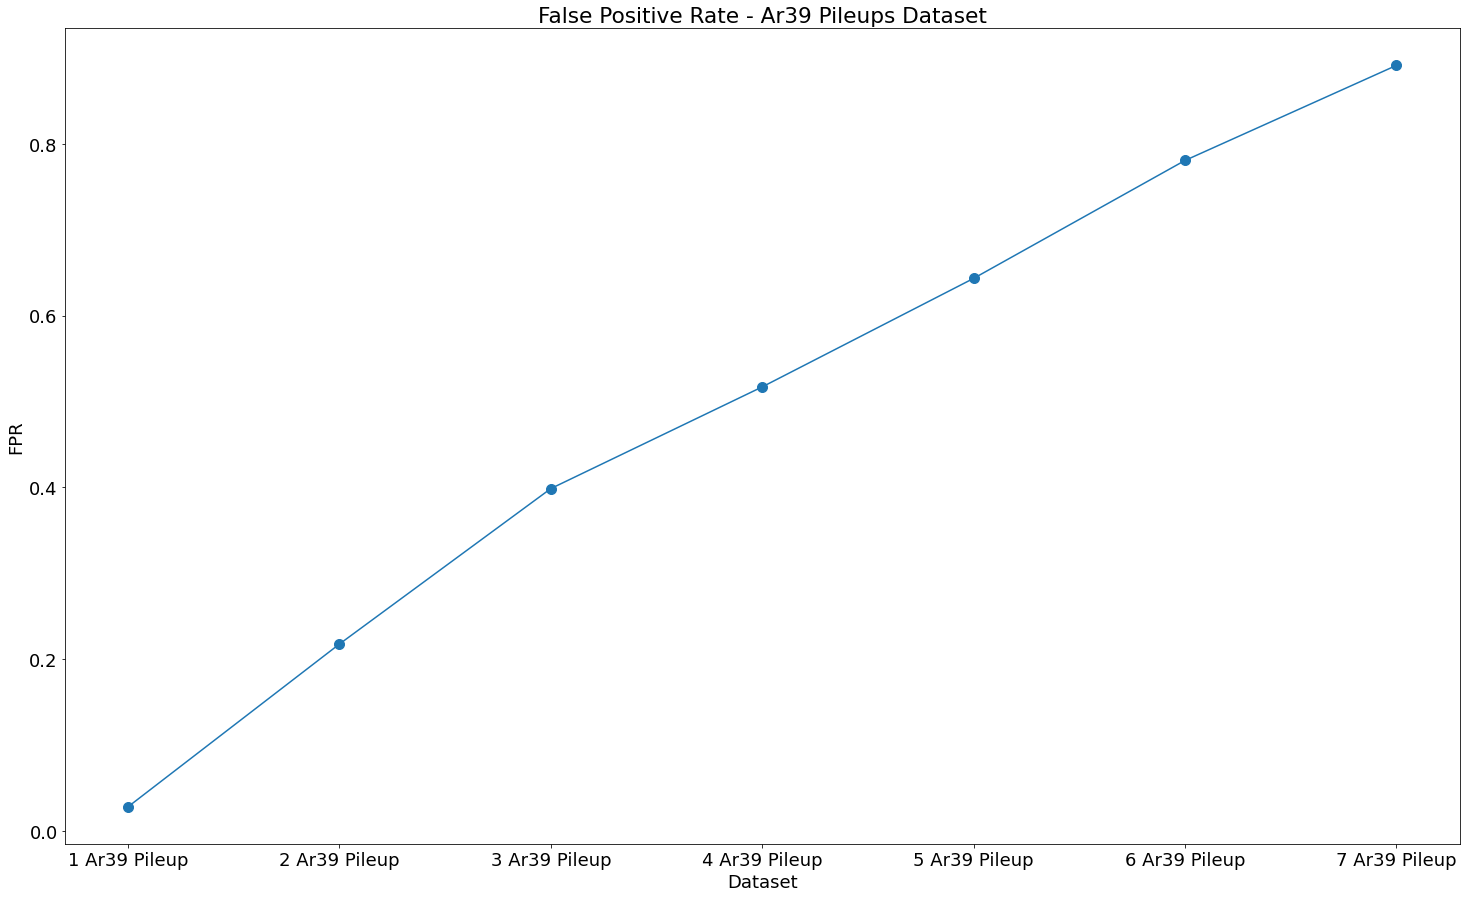

In [8]:
fpr_dfs = []
for ar39_feat, name in zip(ar39_feat_dfs, ar39_dfs_names):
    fpr = len(ar39_feat[ar39_feat.y_pred==1])/len(ar39_feat)
    print("[Info] Dataset: {}, FPR: {}".format(name, fpr))
    fpr_dfs.append(fpr)
plt.plot(np.arange(len(fpr_dfs)), fpr_dfs, marker='.', markersize=20)
plt.title("False Positive Rate - Ar39 Pileups Dataset")
plt.xticks(np.arange(len(fpr_dfs)), ar39_dfs_names)
plt.xlabel("Dataset")
plt.ylabel("FPR")
plt.show()

# Which are the events that pass?

[Info] Dataset: 1 Ar39 Pileup


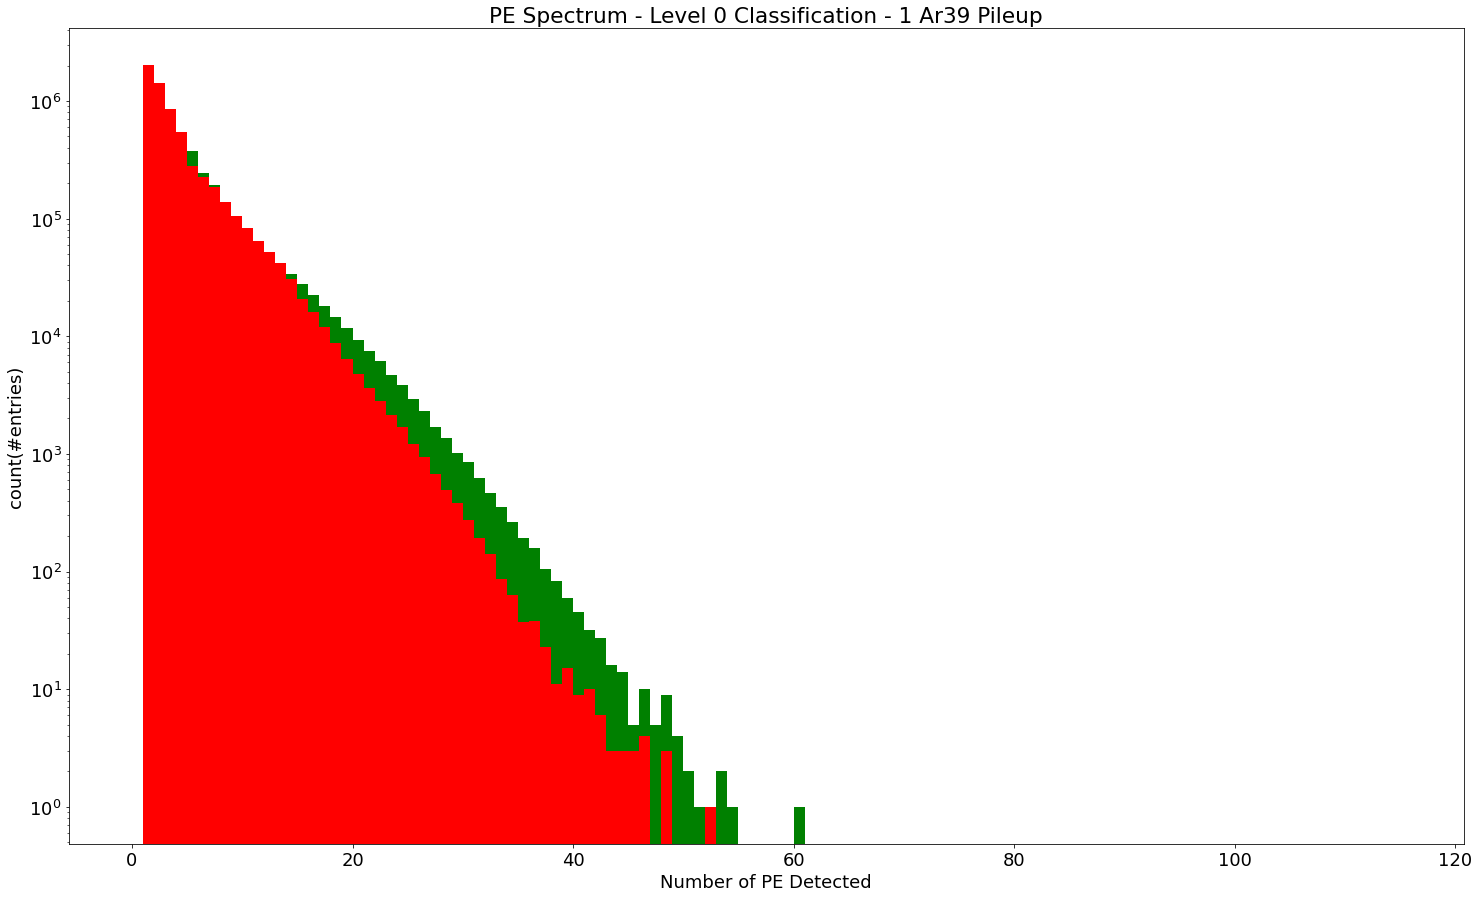

[Info] Dataset: 2 Ar39 Pileup


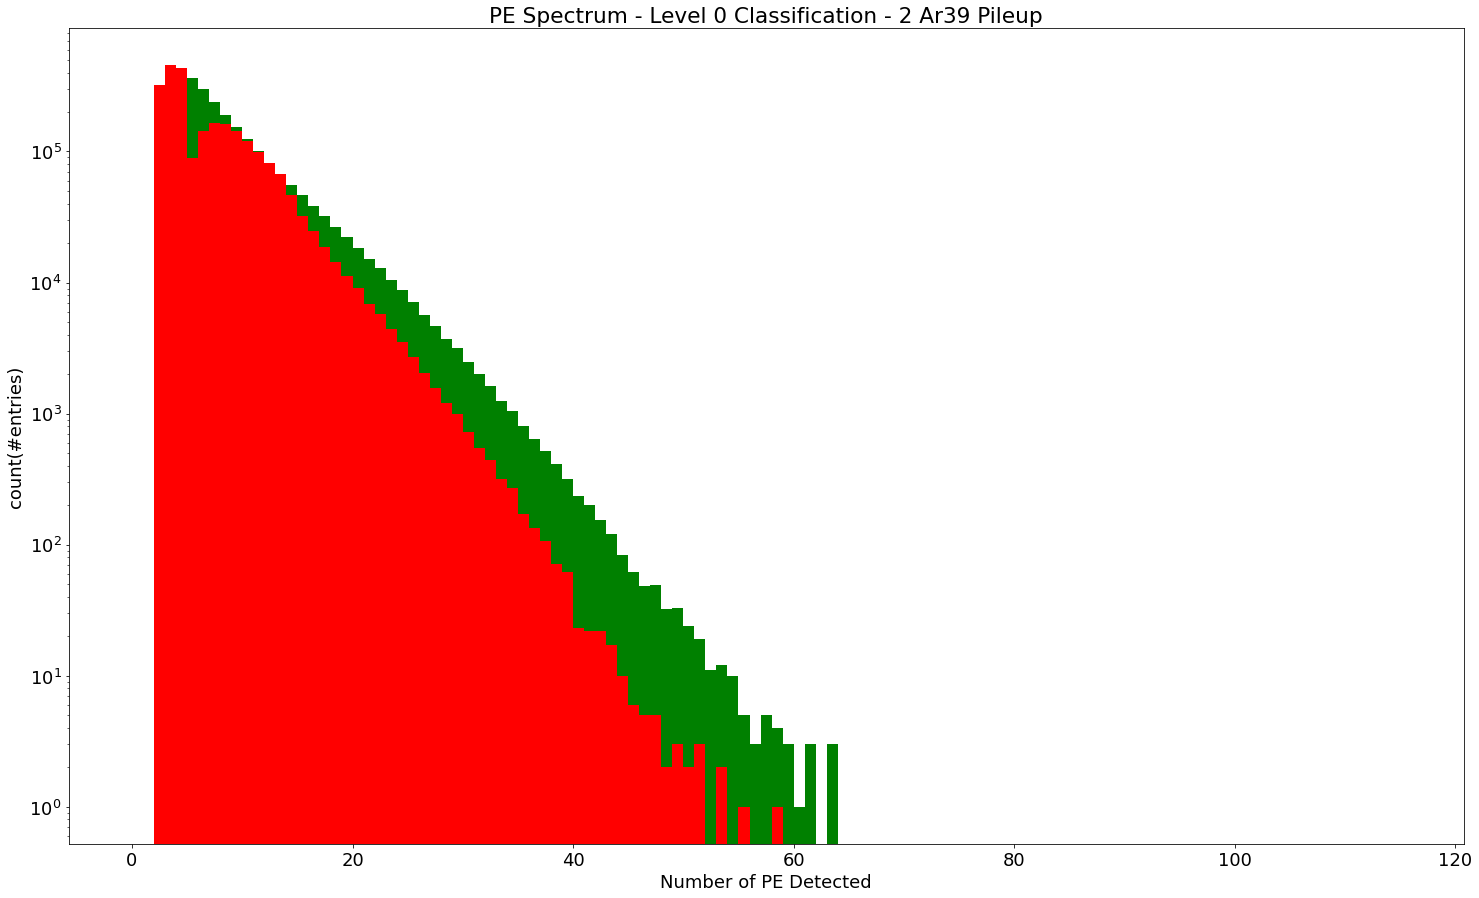

[Info] Dataset: 3 Ar39 Pileup


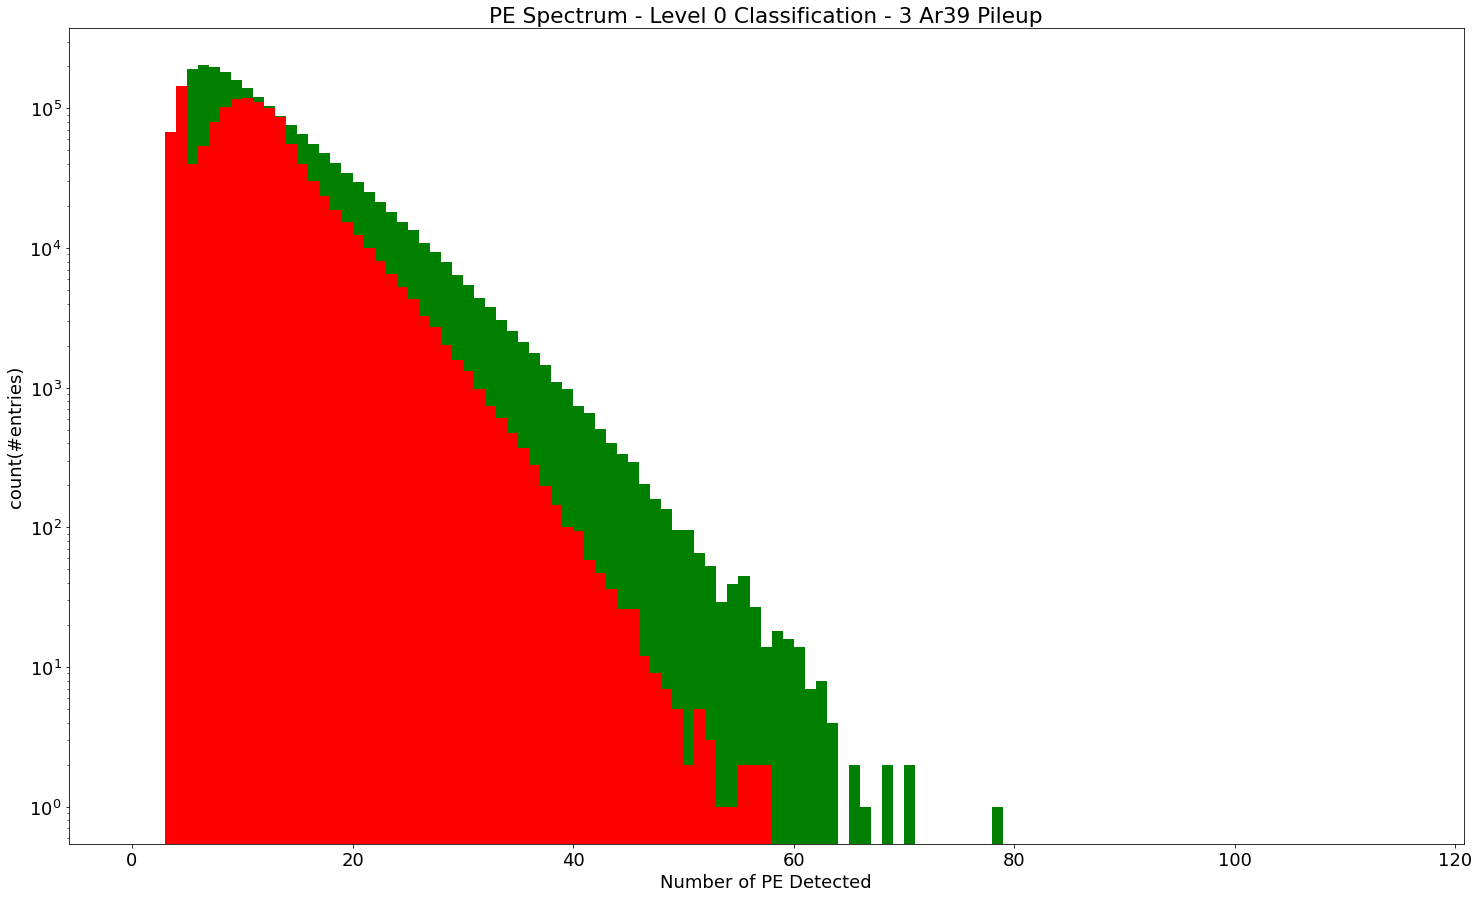

[Info] Dataset: 4 Ar39 Pileup


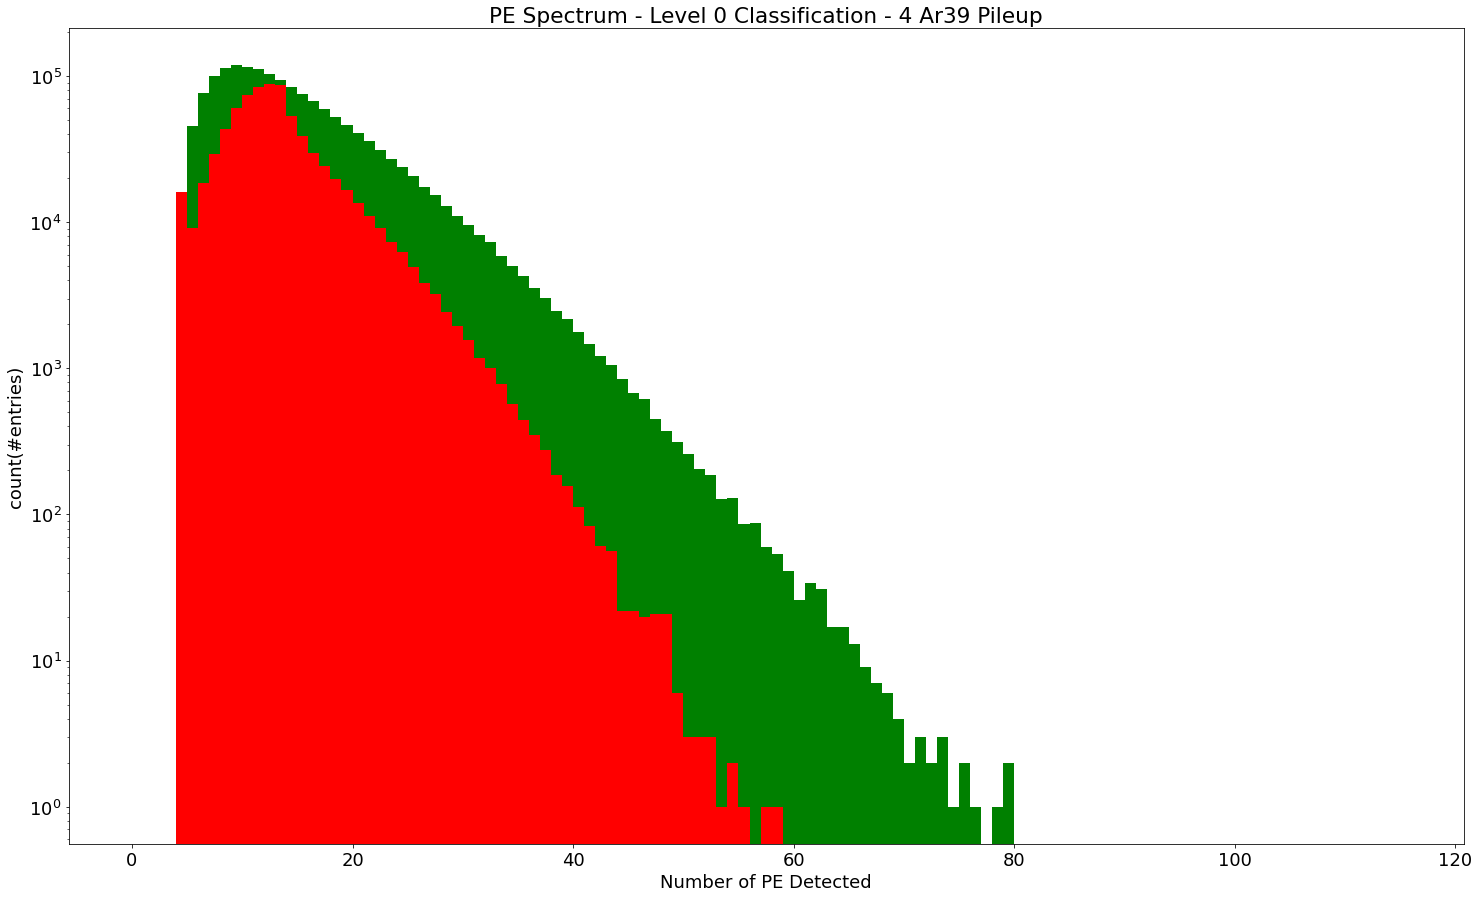

[Info] Dataset: 5 Ar39 Pileup


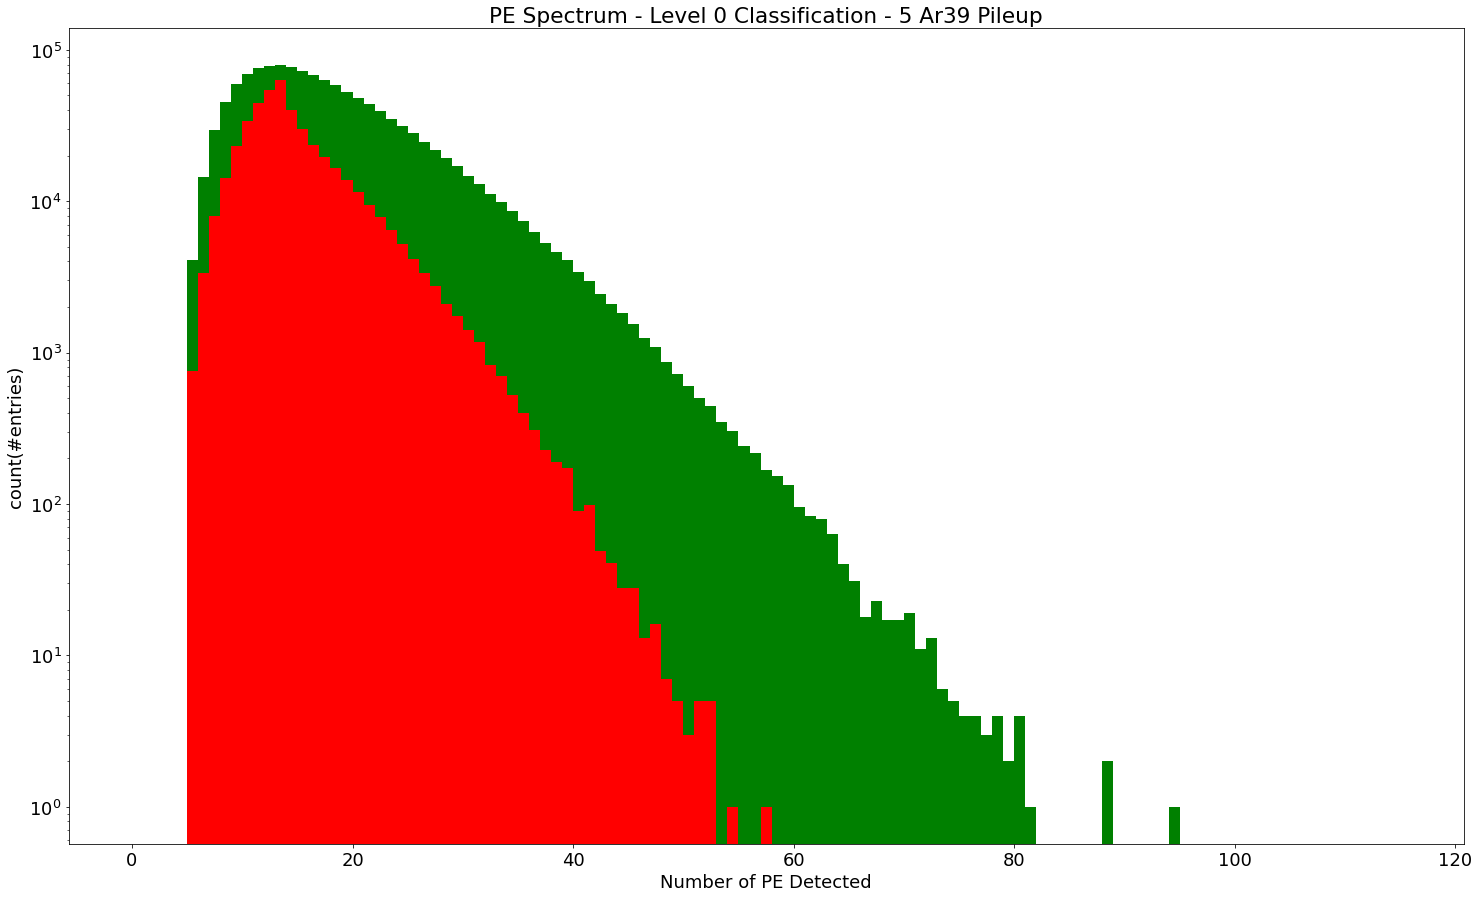

[Info] Dataset: 6 Ar39 Pileup


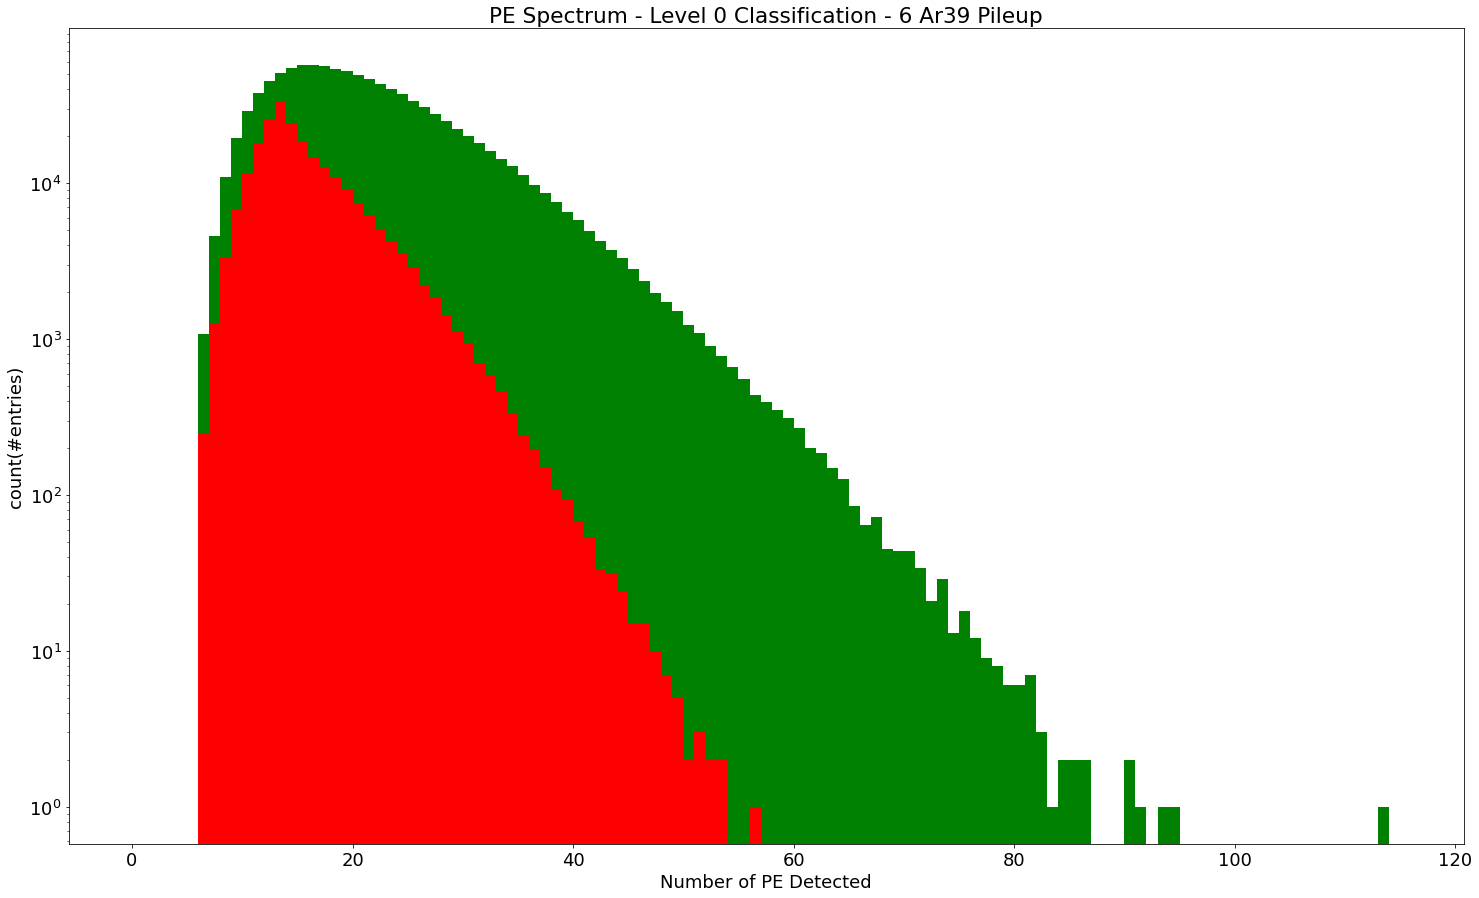

[Info] Dataset: 7 Ar39 Pileup


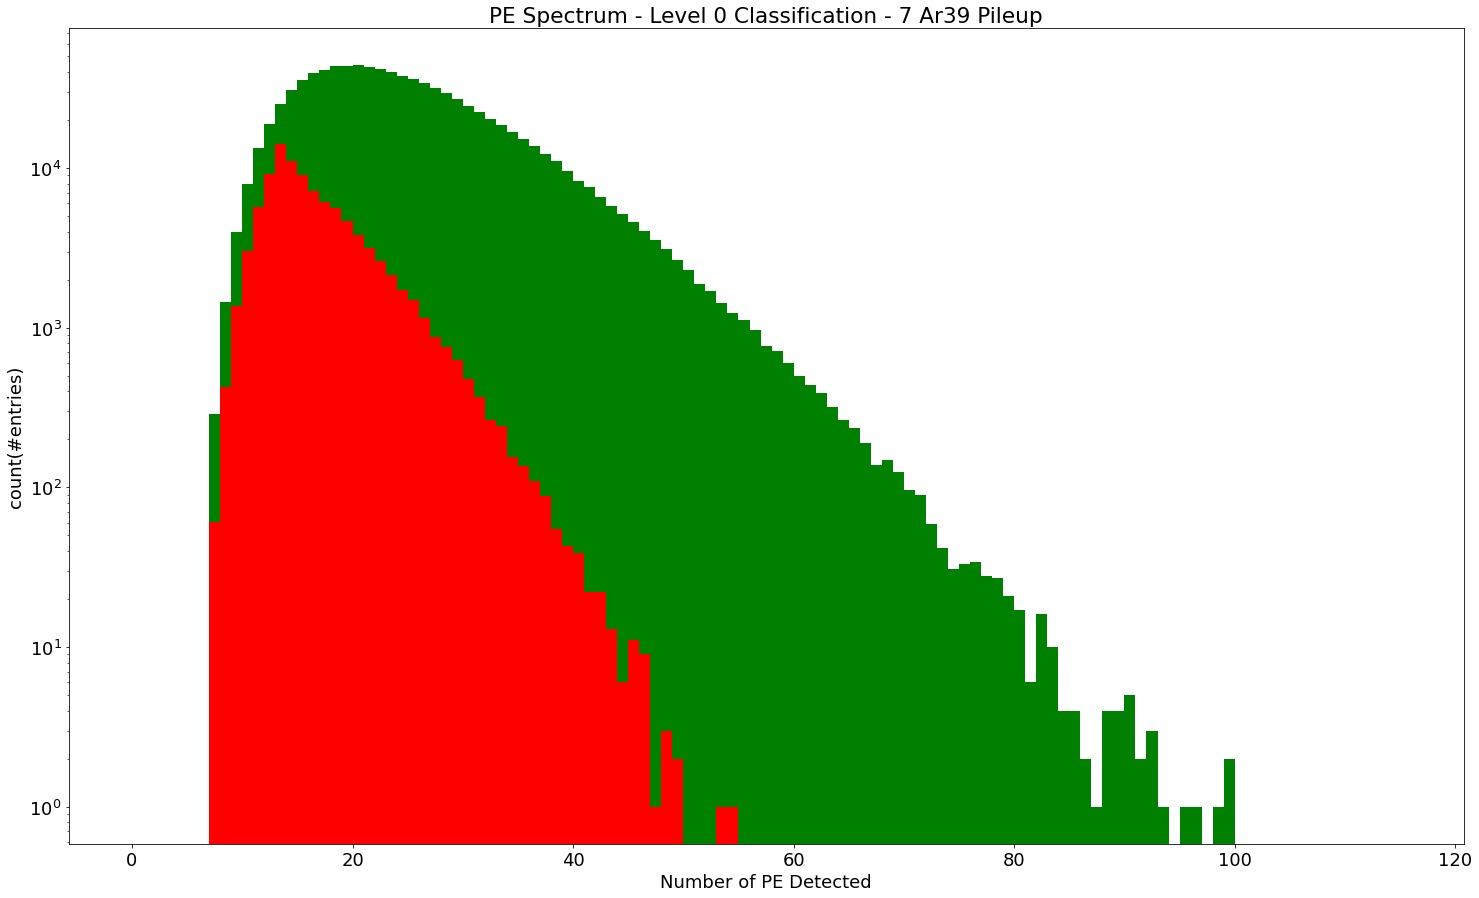

In [9]:
bins = np.linspace(0, 115, 116)
for ar39_feat, name in zip(ar39_feat_dfs, ar39_dfs_names):
    print("[Info] Dataset: {}".format(name))
    ar39_tn = ar39_feat[ar39_feat.y_pred==0]
    plt.hist(ar39_feat.PEDetected_inner+ar39_feat.PEDetected_outer, bins=bins, color="green", label="Accepted")
    plt.hist(ar39_tn.PEDetected_inner+ar39_tn.PEDetected_outer, bins=bins, color="red", label="Rejected")
    plt.title("PE Spectrum - Level 0 Classification - {}".format(name))
    plt.xlabel("Number of PE Detected")
    plt.ylabel("count(#entries)")
    plt.yscale("log")
    plt.show()

# What is the expected rate in this configuration?

In [10]:
# Probabilities of Pileup, given >=1 decay occurred P[k decays|>=1 decay, T=10us])
ar39_pileup_probs = [2.29828021e-02/(1-9.76744672e-01),    #P[1 decay|...]
                     2.70392667e-04/(1-9.76744672e-01),    #P[2 decay|...] 
                     2.12077982e-06/(1-9.76744672e-01),    #P[3 decay|...]
                     1.24754873e-08/(1-9.76744672e-01),    #P[4 decay|...]
                     5.87096432e-11/(1-9.76744672e-01),    #P[5 decay|...]
                     2.30239651e-13/(1-9.76744672e-01),    #P[6 decay|...]
                     7.73934140e-16/(1-9.76744672e-01)]    #P[7 decay|...]

In [11]:
decay_rate = 2353  # Hz
exp_rate = 0
for prob, fpr in zip(ar39_pileup_probs, fpr_dfs):
    exp_rate += prob * fpr
    print("Prob: {}, FPR: {} => Rate: {}".format(prob, fpr, prob * fpr))
print()
print("TOT: Rate: DecayRate * FPR = {} Hz".format(decay_rate * exp_rate))

Prob: 0.9882811414227327, FPR: 0.028126871845056918 => Rate: 0.027797257011683774
Prob: 0.011627127641459213, FPR: 0.21759204222353887 => Rate: 0.002529970448698869
Prob: 9.119543787987008e-05, FPR: 0.39855888088584174 => Rate: 3.634675166329532e-05
Prob: 5.364571637088937e-07, FPR: 0.5169477984980941 => Rate: 2.773203497678443e-07
Prob: 2.5245674109606234e-09, FPR: 0.6432688146817842 => Rate: 1.623975486032901e-09
Prob: 9.900511874096137e-12, FPR: 0.7805673699507727 => Rate: 7.728016514729617e-12
Prob: 3.327986343602641e-14, FPR: 0.8912115042136624 => Rate: 2.965939715284636e-14

TOT: Rate: DecayRate * FPR = 71.44614649519522 Hz


# Observations:
This is a very good starting point. We such a low trigger rate, thanks to the first cut performed, we can refine the selection of muons with more sophisticated model!